In [1]:
import sys
sys.path.append('/content/')
import numpy as np
import tensorflow as tf
from skimage.draw import disk
import matplotlib.pyplot as plt
import plotting_functions as plf

def discGenerator(res=256):
    while True:
        center = tf.random.uniform([2], minval=0, maxval=res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval=res // 2, dtype=tf.int32, name='radius')
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx, yy] = 1
        features = tf.concat(values=(center, radius), axis=0)
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield features, label

features = []
labels = []
res = 256

for index, item in enumerate(discGenerator(res)):
    if index == 1024:
        break
    features.append(item[0])
    labels.append(item[1])

features = np.array(features).reshape(-1, 3)
labels = np.array(labels).reshape(-1, res, res, 1)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)



Features shape: (1024, 3)
Labels shape: (1024, 256, 256, 1)


In [2]:
res = 256

model_fc = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(3,)),
    tf.keras.layers.Dense(16, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer="HeNormal"),
    tf.keras.layers.Dense(64, activation='relu',  # Reduced units
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer="HeNormal"),
    tf.keras.layers.Dense(res*res, activation='sigmoid',  # Output layer with res*res units
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer="HeNormal"),
    tf.keras.layers.Reshape((res, res, 1)),
], name="FC_disc_generator")

model_fc.summary()

Model: "FC_disc_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 65536)          │     4,259,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,260,992 (16.25 MB)

 Trainable params: 4,260,992 (16.25 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Encoder
encoder = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(256, 256, 1)),  # Changed input shape
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='relu')
], name='encoder')

encoder.summary()

# Decoder
decoder = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(4, 4, 1)),  # Changed input shape
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid') # Changed output shape
], name='decoder')
decoder.summary()

model_cnn_ae = tf.keras.Sequential(layers=[encoder, decoder], name='autoencoder')
model_cnn_ae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 1)        │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 8, 8, 32)       │           320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 256, 256, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 4, 4, 1)        │        19,105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 256, 256, 1)    │        46,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,954 (257.63 KB)

 Trainable params: 65,954 (257.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8381 - loss: 2.3445 - val_accuracy: 0.8503 - val_loss: 2.2163
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8391 - loss: 2.3723 - val_accuracy: 0.8515 - val_loss: 2.2124
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8402 - loss: 2.3524 - val_accuracy: 0.8513 - val_loss: 2.2094
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8413 - loss: 2.3369 - val_accuracy: 0.8494 - val_loss: 2.2091
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8447 - loss: 2.2727 - val_accuracy: 0.8506 - val_loss: 2.2018
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8453 - loss: 2.2594 - val_accuracy: 0.8518 - val_loss: 2.1932
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8410 - loss: 2.3350 - val_accuracy: 0.8521 - val_loss: 2.1864
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8412 - loss: 2.3289 - val_accuracy: 0.

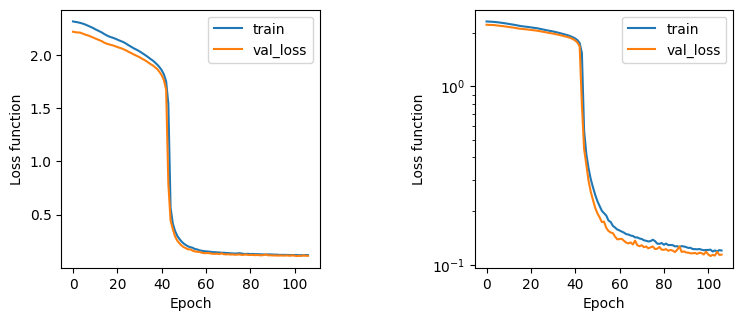

In [9]:
import tensorflow as tf

# training the Fully Connected Network (model_fc)

initial_learning_rate = 1E-3
batchSize = 64
nEpochs = 500

nStepsPerEpoch = int(len(labels) / batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=nStepsPerEpoch * 10,
    decay_rate=0.95,
    staircase=False
)

model_fc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping_fc = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fc = model_fc.fit(
    x=features,
    y=labels,
    epochs=nEpochs,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping_fc]
)
plf.plotTrainHistory(history_fc)


Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9736 - loss: 0.0761 - val_accuracy: 0.9820 - val_loss: 0.0443
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9856 - loss: 0.0364 - val_accuracy: 0.9860 - val_loss: 0.0358
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9881 - loss: 0.0316 - val_accuracy: 0.9865 - val_loss: 0.0349
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9882 - loss: 0.0313 - val_accuracy: 0.9867 - val_loss: 0.0347
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9880 - loss: 0.0313 - val_accuracy: 0.9867 - val_loss: 0.0345
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9883 - loss: 0.0311 - val_accuracy: 0.9862 - val_loss: 0.0353
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9879 - loss: 0.0320 - val_accuracy: 0.9865 - val_loss: 0.0347
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9887 - loss: 0.0299 - val_accuracy: 

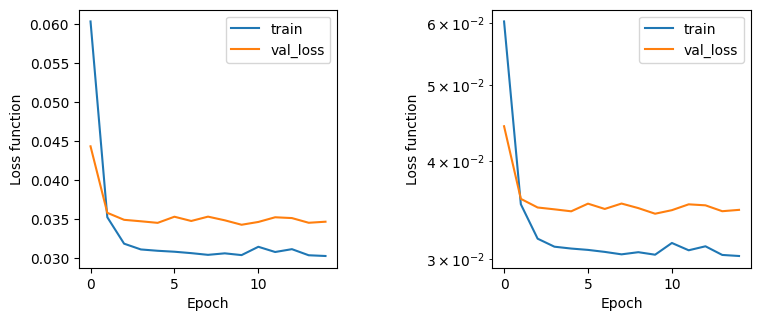

In [10]:

# training the Autoencoder Network (model_cnn_ae)

initial_learning_rate = 1E-3
batchSize = 32
nEpochs = 500

nStepsPerEpoch = int(len(labels) / batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=nStepsPerEpoch * 10,
    decay_rate=0.95,
    staircase=False
)

model_cnn_ae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']  # Add accuracy metric
)

early_stopping_ae = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_ae = model_cnn_ae.fit(
    x=labels,
    y=labels,
    epochs=nEpochs,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping_ae]  # Add early stopping callback
)

plf.plotTrainHistory(history_ae)

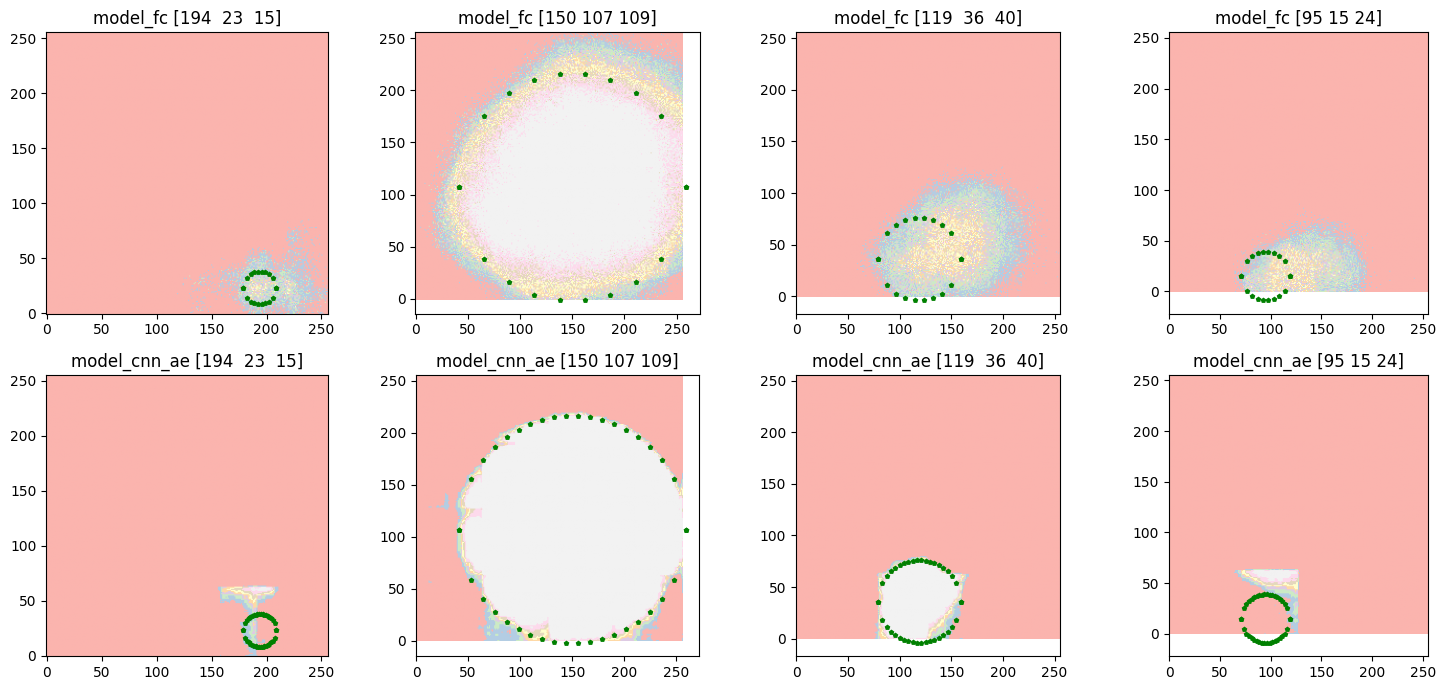

Model Sizes:
model_fc: 4260992
model_cnn_ae: 65954


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plotGeneral(model_fc, model_cnn, params, num_examples=4):
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 7))

    # Choose random indices
    indices = np.arange(num_examples) #first four

    # Plot for model_fc (first row)
    for i, ax in enumerate(axes[0]):
        index = indices[i]
        features_tensor = tf.Variable([params[index]], dtype=tf.int16)
        image = model_fc(features_tensor)[0]
        ax.imshow(image, cmap='Pastel1', origin='lower')
        ax.set_title('model_fc ' + str(params[index]))
        # Plot the nominal circle
        x = np.linspace(-params[index][2], params[index][2], 10)
        y = np.sqrt(params[index][2]**2 - x**2)
        y = np.concatenate((y, -y), axis=0)
        x = np.concatenate((x, x), axis=0)
        x += params[index][0]
        y += params[index][1]
        ax.plot(x, y, "p", markersize=3, color='green')

    # Plot for model_cnn_ae (second row)
    for i, ax in enumerate(axes[1]):
        data_index = indices[i]  # Use the same random indices
        image = labels[data_index:data_index + 1]
        model_cnn.evaluate(image, image, verbose=0)  # Suppress evaluation output
        z = encoder.predict(image, verbose=0)
        image = decoder.predict(z, verbose=0)[0, :, :, 0]
        ax.imshow(image, cmap='Pastel1', origin='lower')
        ax.set_title('model_cnn_ae ' + str(features[data_index]))
        # Plot the nominal circle
        x = np.linspace(-features[data_index][2], features[data_index][2], 20)
        y = np.sqrt(features[data_index][2]**2 - x**2)
        y = np.concatenate((y, -y), axis=0)
        x = np.concatenate((x, x), axis=0)
        y += features[data_index][1]
        x += features[data_index][0]
        ax.plot(x, y, "p", markersize=3, color='green')

    plt.tight_layout()
    plt.show()

plotGeneral(model_fc, model_cnn_ae, features)
plt.show()

# print Model Sizes
print("Model Sizes:")
print("model_fc:", model_fc.count_params())
print("model_cnn_ae:", model_cnn_ae.count_params())